In [144]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, avg, count, unix_timestamp
import pandas as pd
import matplotlib.pyplot as plt
import os
import pyspark
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import seaborn as sns

In [80]:
def expand_temperatures(df):
    hourly_temperatures = pd.DataFrame()
    for i, row in df.iterrows():
        daily_temps = pd.DataFrame({
            'hour': range(24),
            'Temperature (°C)': row['Temperature (°C)'],
            'Feels Like (°C)': row['Feels Like (°C)']
        })
        hourly_temperatures = pd.concat([hourly_temperatures, daily_temps], ignore_index=True)
    return hourly_temperatures

# Spark 세션 생성

In [21]:
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.bindAddress", "0.0.0.0") \
    .getOrCreate()

24/08/04 16:01:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Parquet 파일 로드

In [81]:
file_path = "data/yellow_tripdata_2024-01.parquet"
df = spark.read.parquet(file_path)

# 데이터 프레임 스키마 확인

In [82]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



# 누락된 값 제거

In [83]:
df = df.dropna()

# 전처리

In [84]:
df = df.withColumn("pickup_datetime", to_timestamp(col("tpep_pickup_datetime"))).withColumn("dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

df = df.filter((col("trip_distance") > 0) & (col("tpep_dropoff_datetime") > col("tpep_pickup_datetime")))

# 여행 시간

In [85]:
df = df.withColumn("trip_duration", (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60)

# 평균 여행 시간, 거리

In [86]:
avg_trip_duration = df.agg(avg("trip_duration")).first()[0]
avg_trip_distance = df.agg(avg("trip_distance")).first()[0]

# 평균 기간

In [87]:
avg_trip_duration

15.712503070961404

# 평균 거리

In [88]:
avg_trip_distance

3.297896803497036

# 시간대 추출

In [89]:
df = df.withColumn("hour", hour(col("pickup_datetime")))
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, pickup_datetime: timestamp, dropoff_datetime: timestamp, trip_duration: double, hour: int]

# 시간대별 여행 수 계산

In [90]:
hourly_trips = df.groupBy("hour").agg(count("*").alias("trip_count")).orderBy("hour")

# 피크타임

In [91]:
hourly_trips_pd = hourly_trips.toPandas()
peak_hour = hourly_trips_pd.loc[hourly_trips_pd['trip_count'].idxmax()]

# 시각화

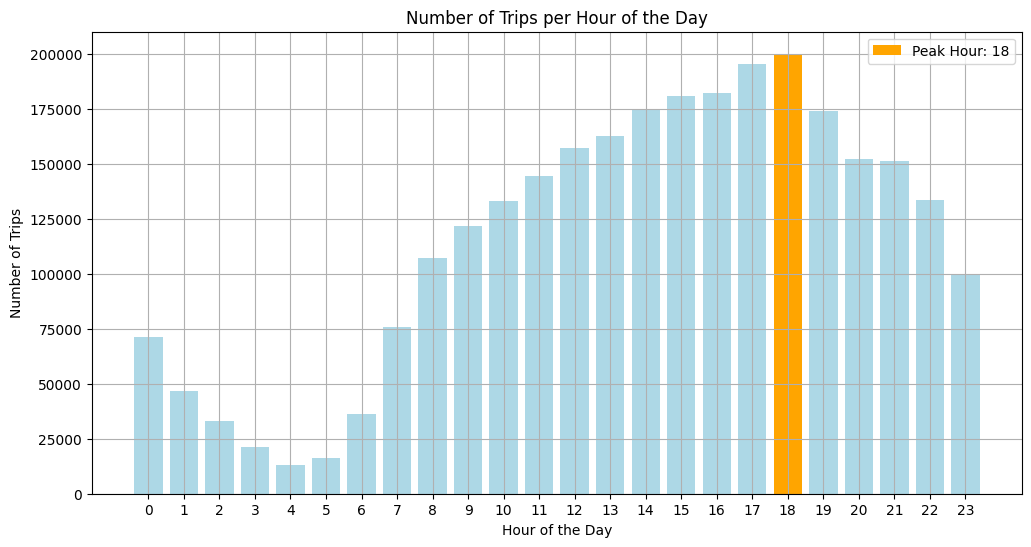

In [92]:
plt.figure(figsize=(12, 6))
plt.bar(hourly_trips_pd["hour"], hourly_trips_pd["trip_count"], color='lightblue')
plt.bar(peak_hour["hour"], peak_hour["trip_count"], color='orange', label=f"Peak Hour: {peak_hour['hour']}")

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Number of Trips per Hour of the Day")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

## 고찰
* 퇴근 시간이라 택시를 이용하는 사람이 많을 것이다.
* 추운 1월이라 택시를 이용하는 사람이 다른 계절보다 더 많이 나타났을 것이다.

# 저장

In [93]:
output_dir = "results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 결과 저장
output_path = os.path.join(output_dir, "hourly_trips.csv")
hourly_trips_pd.to_csv(output_path, index=False)

# 뉴옥 2024년 1월 날씨 정보 url

In [151]:
base_url = "https://world-weather.info"
main_url = "https://world-weather.info/forecast/usa/new_york/january-2024/"

# Define headers

In [152]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

In [153]:
response = requests.get(main_url, headers=headers)
response.raise_for_status()

In [154]:
soup = BeautifulSoup(response.content, "html.parser")
forecast_items = soup.select("ul.ww-month li.foreacast-archive a")

In [155]:
dates = []
night_temps = []
morning_temps = []
day_temps = []
evening_temps = []

In [156]:
def extract_temperature(span_text):
    return int(span_text.replace("°", "").replace("+", "").replace("−", "-"))

# 날짜, 최고기온, 최저기온 추출

In [157]:
for item in forecast_items:
    # Get the date from the div text
    date = item.find("div").get_text()
    dates.append(date)
    
    # Get the URL for the detailed forecast
    detail_url = urljoin(base_url, item['href'])
    
    # Send a GET request to the detailed forecast webpage
    detail_response = requests.get(detail_url, headers=headers)
    detail_response.raise_for_status()
    
    # Parse the detailed forecast webpage content
    detail_soup = BeautifulSoup(detail_response.content, "html.parser")
    
    # Extract temperatures for night, morning, day, evening
    night_temp = extract_temperature(detail_soup.select_one("tr.night td.weather-temperature span").get_text())
    morning_temp = extract_temperature(detail_soup.select_one("tr.morning td.weather-temperature span").get_text())
    day_temp = extract_temperature(detail_soup.select_one("tr.day td.weather-temperature span").get_text())
    evening_temp = extract_temperature(detail_soup.select_one("tr.evening td.weather-temperature span").get_text())
    
    night_temps.append(night_temp)
    morning_temps.append(morning_temp)
    day_temps.append(day_temp)
    evening_temps.append(evening_temp)

In [158]:
data = {
    "Date": dates,
    "Night Temperature (°F)": night_temps,
    "Morning Temperature (°F)": morning_temps,
    "Day Temperature (°F)": day_temps,
    "Evening Temperature (°F)": evening_temps
}

In [159]:
df = pd.DataFrame(data)
df

,Date,Night Temperature (°F),Morning Temperature (°F),Day Temperature (°F),Evening Temperature (°F)
0,1,43,41,45,41
1,2,36,32,39,43
2,3,39,36,41,39
3,4,39,39,43,34
4,5,30,28,36,37
5,6,36,34,37,36
6,7,37,37,34,36
7,8,39,37,43,43
8,9,37,37,45,46
9,10,52,46,45,45


# 섭씨 온도로 변환

In [160]:
df["Night Temperature (°C)"] = (df["Night Temperature (°F)"] - 32) * 5.0 / 9.0
df["Morning Temperature (°C)"] = (df["Morning Temperature (°F)"] - 32) * 5.0 / 9.0
df["Day Temperature (°C)"] = (df["Day Temperature (°F)"] - 32) * 5.0 / 9.0
df["Evening Temperature (°C)"] = (df["Evening Temperature (°F)"] - 32) * 5.0 / 9.0

# 시간 별 기온

In [161]:
df

,Date,Night Temperature (°F),Morning Temperature (°F),Day Temperature (°F),Evening Temperature (°F),Night Temperature (°C),Morning Temperature (°C),Day Temperature (°C),Evening Temperature (°C)
0,1,43,41,45,41,6.111111,5.000000,7.222222,5.000000
1,2,36,32,39,43,2.222222,0.000000,3.888889,6.111111
2,3,39,36,41,39,3.888889,2.222222,5.000000,3.888889
3,4,39,39,43,34,3.888889,3.888889,6.111111,1.111111
4,5,30,28,36,37,-1.111111,-2.222222,2.222222,2.777778
5,6,36,34,37,36,2.222222,1.111111,2.777778,2.222222
6,7,37,37,34,36,2.777778,2.777778,1.111111,2.222222
7,8,39,37,43,43,3.888889,2.777778,6.111111,6.111111
8,9,37,37,45,46,2.777778,2.777778,7.222222,7.777778
9,10,52,46,45,45,11.111111,7.777778,7.222222,7.222222


# 시간 별 택시 이용 수

In [162]:
hourly_trips_pd

,hour,trip_count,period
0,0,71102,Night
1,1,46585,Night
2,2,32942,Night
3,3,21255,Night
4,4,13286,Night
5,5,16105,Night
6,6,36418,Morning
7,7,75956,Morning
8,8,107450,Morning
9,9,122027,Morning


In [163]:
periods = {
    'Night': list(range(0, 6)),
    'Morning': list(range(6, 12)),
    'Day': list(range(12, 18)),
    'Evening': list(range(18, 24))
}

In [186]:
hourly_trips_pd['period'] = hourly_trips_pd['hour'].apply(lambda x: 'Night' if x in periods['Night'] else ('Morning' if x in periods['Morning'] else ('Day' if x in periods['Day'] else 'Evening')))

In [187]:
df['Night_trip_count'] = 0
df['Morning_trip_count'] = 0
df['Day_trip_count'] = 0
df['Evening_trip_count'] = 0
df

,Date,Night Temperature (°F),Morning Temperature (°F),Day Temperature (°F),Evening Temperature (°F),Night Temperature (°C),Morning Temperature (°C),Day Temperature (°C),Evening Temperature (°C),Night_trip_count,Morning_trip_count,Day_trip_count,Evening_trip_count
0,1,43,41,45,41,6.111111,5.000000,7.222222,5.000000,0,0,0,0
1,2,36,32,39,43,2.222222,0.000000,3.888889,6.111111,0,0,0,0
2,3,39,36,41,39,3.888889,2.222222,5.000000,3.888889,0,0,0,0
3,4,39,39,43,34,3.888889,3.888889,6.111111,1.111111,0,0,0,0
4,5,30,28,36,37,-1.111111,-2.222222,2.222222,2.777778,0,0,0,0
5,6,36,34,37,36,2.222222,1.111111,2.777778,2.222222,0,0,0,0
6,7,37,37,34,36,2.777778,2.777778,1.111111,2.222222,0,0,0,0
7,8,39,37,43,43,3.888889,2.777778,6.111111,6.111111,0,0,0,0
8,9,37,37,45,46,2.777778,2.777778,7.222222,7.777778,0,0,0,0
9,10,52,46,45,45,11.111111,7.777778,7.222222,7.222222,0,0,0,0


In [191]:
for i, date in enumerate(df['Date']):
    # Filter the trip counts for the specific date
    daily_trip_counts = hourly_trips_pd[(hourly_trips_pd['hour'] // 24) == i]

    # Sum trip counts for each period
    df.at[i, 'Night_trip_count'] = daily_trip_counts[daily_trip_counts['period'] == 'Night']['trip_count'].sum()
    df.at[i, 'Morning_trip_count'] = daily_trip_counts[daily_trip_counts['period'] == 'Morning']['trip_count'].sum()
    df.at[i, 'Day_trip_count'] = daily_trip_counts[daily_trip_counts['period'] == 'Day']['trip_count'].sum()
    df.at[i, 'Evening_trip_count'] = daily_trip_counts[daily_trip_counts['period'] == 'Evening']['trip_count'].sum()


In [192]:
correlation_matrix = df[[
    'Night Temperature (°C)', 'Morning Temperature (°C)', 
    'Day Temperature (°C)', 'Evening Temperature (°C)', 
    'Night_trip_count', 'Morning_trip_count', 
    'Day_trip_count', 'Evening_trip_count'
]].corr()
correlation_matrix

,Night Temperature (°C),Morning Temperature (°C),Day Temperature (°C),Evening Temperature (°C),Night_trip_count,Morning_trip_count,Day_trip_count,Evening_trip_count
Night Temperature (°C),1.000000,0.949437,0.869175,0.769888,0.161625,0.161625,0.161625,0.161625
Morning Temperature (°C),0.949437,1.000000,0.930229,0.822432,0.147545,0.147545,0.147545,0.147545
Day Temperature (°C),0.869175,0.930229,1.000000,0.877694,0.185123,0.185123,0.185123,0.185123
Evening Temperature (°C),0.769888,0.822432,0.877694,1.000000,0.095876,0.095876,0.095876,0.095876
Night_trip_count,0.161625,0.147545,0.185123,0.095876,1.000000,1.000000,1.000000,1.000000
Morning_trip_count,0.161625,0.147545,0.185123,0.095876,1.000000,1.000000,1.000000,1.000000
Day_trip_count,0.161625,0.147545,0.185123,0.095876,1.000000,1.000000,1.000000,1.000000
Evening_trip_count,0.161625,0.147545,0.185123,0.095876,1.000000,1.000000,1.000000,1.000000


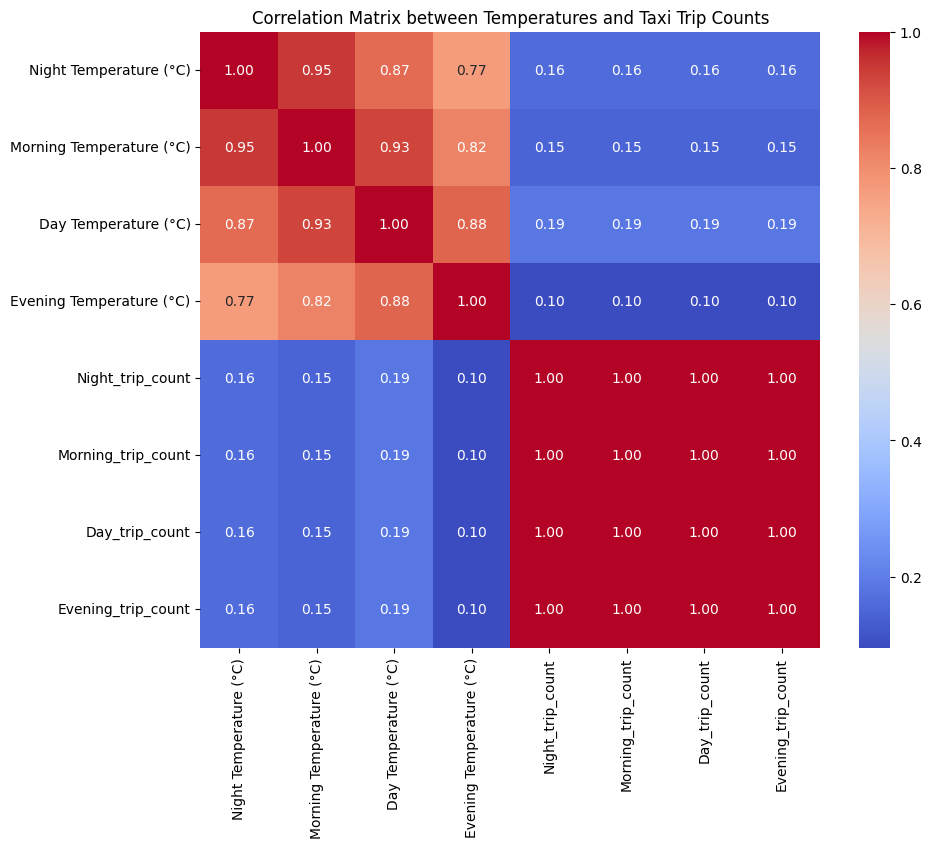

In [193]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Temperatures and Taxi Trip Counts')
plt.show()

## 결론
* Evening보다 Day, Night가 택시 이용수가 많았다.